In [69]:
from langgraph.graph import StateGraph,START,END
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from dotenv import load_dotenv
load_dotenv()
from langchain_community.document_loaders import PyPDFLoader
from langchain_classic.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.tools import tool
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, BaseMessage,SystemMessage
from langgraph.prebuilt import ToolNode, tools_condition

In [70]:

embedding=HuggingFaceEmbeddings(model="sentence-transformers/all-MiniLM-L6-v2")

In [71]:
llm=ChatGroq(model_name="openai/gpt-oss-20b")

In [72]:
loader = PyPDFLoader("Effective Approaches to Attention-based Neural Machine Translation.pdf")
docs = loader.load()

In [73]:


len(docs)

11

In [74]:
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_documents(docs)

In [75]:
len(chunks)

54

In [76]:
chunks[0]

Document(metadata={'producer': 'dvips + GPL Ghostscript GIT PRERELEASE 9.08', 'creator': 'LaTeX with hyperref package', 'creationdate': '2015-09-21T20:33:39-04:00', 'moddate': '2015-09-21T20:33:39-04:00', 'title': '', 'subject': '', 'author': '', 'keywords': '', 'source': 'Effective Approaches to Attention-based Neural Machine Translation.pdf', 'total_pages': 11, 'page': 0, 'page_label': '1'}, page_content='arXiv:1508.04025v5  [cs.CL]  20 Sep 2015\nEffective Approaches to Attention-based Neural Machine Translation\nMinh-Thang Luong Hieu Pham Christopher D. Manning\nComputer Science Department, Stanford University, Stanford, CA 94305\n{lmthang,hyhieu,manning}@stanford.edu\nAbstract\nAn attentional mechanism has lately been\nused to improve neural machine transla-\ntion (NMT) by selectively focusing on\nparts of the source sentence during trans-\nlation. However, there has been little\nwork exploring useful architectures for\nattention-based NMT. This paper exam-\nines two simple and eff

In [77]:
vector_store=FAISS.from_documents(chunks,embedding)

In [78]:
vector_store

In [79]:
retriever = vector_store.as_retriever(search_type='similarity', search_kwargs={'k':4})

In [80]:
result=retriever.invoke("attention is a key")

In [81]:
@tool
def rag_tool(query):

    """
    Retrieve relevant information from the pdf document.
    Use this tool when the user asks factual / conceptual questions
    that might be answered from the stored documents.
    """
    result = retriever.invoke(query)

    context = [doc.page_content for doc in result]
    metadata = [doc.metadata for doc in result]

    return {
        'query': query,
        'context': context,
        'metadata': metadata
    }

In [82]:
tools = [rag_tool]
llm_with_tools = llm.bind_tools(tools)

In [83]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [84]:
def chat_node(state: ChatState):

    messages = state['messages']

    response = llm_with_tools.invoke(messages)

    return {'messages': [response]}

In [85]:

tool_node = ToolNode(tools)

In [86]:
graph = StateGraph(ChatState)

graph.add_node('chat_node', chat_node)
graph.add_node('tools', tool_node)

graph.add_edge(START, 'chat_node')
graph.add_conditional_edges('chat_node', tools_condition)
graph.add_edge('tools', 'chat_node')

chatbot = graph.compile()

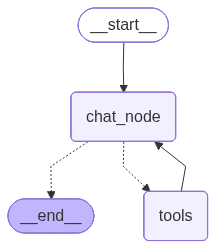

In [87]:
chatbot

In [93]:
result = chatbot.invoke(
    {
        "messages": [
            
            
            HumanMessage(
                content=(
                    "what is attention "
                )
            )
        ]
    }
)

In [94]:
print(result['messages'][-1].content)

### Attention – A Quick Overview

**Attention** is a mechanism in machine learning (especially in natural language processing, computer vision, and multimodal tasks) that allows a model to focus on the most relevant parts of its input when making a prediction. Think of it like a spotlight that highlights the most important words, image regions, or other features, letting the model weigh them more heavily than irrelevant or noisy parts.

---

#### 1. Why Attention Was Introduced
- **Limitations of RNNs**: Recurrent networks (LSTMs, GRUs) struggle to remember long‑range dependencies because information gets diluted as it passes through many time‑steps.
- **Fixed‑size context**: Traditional encoders produce a single fixed‑length vector that must capture all relevant information, which is hard for long sequences.
- **Parallelization**: Attention can be computed in parallel across all positions, speeding up training and inference.

---

#### 2. Core Idea
At its heart, attention computes a *